# Using MonoTools.fit with RVs

I don;t have a good example to hand, so let's use synthetic data.

First lets' import what we need:

In [1]:
from MonoTools.MonoTools import fit,tools

%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import exoplanet as xo

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


##### The data
Let's create two fake TESS datasets with 30d observations and a 300d gap. 

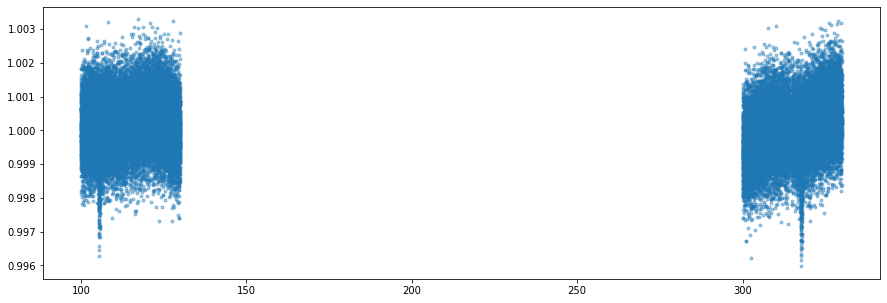

In [2]:
x = np.concatenate((np.arange(100,114.25,2/1440), np.arange(114.75,130,2/1440),
                    np.arange(300,314.25,2/1440), np.arange(314.75,330,2/1440)))

#Adding some randomised sinusoids to mimic stellar variability:
y_sv=abs(np.random.normal(0.0002,0.0005))*np.sin((x+np.random.random()*2*np.pi)/(np.random.normal(8,1)))+abs(np.random.normal(0.0001,0.0005))*np.sin((x+np.random.random()*2*np.pi)/(np.random.normal(3,0.8)))

#Now adding noise to the lightcurve
noise=0.0008
y = np.random.normal(1.0,noise,len(x))+y_sv
yerr = noise*1.1+np.zeros_like(y)

it0=105.57

#Depth here is a little over double the per-point scatter
idepth=0.0018

true_orbit = xo.orbits.KeplerianOrbit(period=35.36789, t0=it0, b=0.2, omega=0.72, ecc=0.025)
true_model = xo.LimbDarkLightCurve([0.3, 0.2]).get_light_curve(orbit=true_orbit, t=x, r=np.sqrt(idepth)).eval()[:, 0]
y += true_model

#plotting the data:
plt.figure(figsize=(15,5))
plt.plot(x, y,'.',alpha=0.4);

#### Generating the fake RV data


In [10]:
#Taking 25 randomly-sampled RVs over a range starting 30d after the last orbit finished
x_rv=np.sort(360+80*np.random.random(25))

# Getting an RV with a semi-major axis
pure_rvs=true_orbit.get_radial_velocity(x_rv, K=10).eval()

#Adding 8.1m/s scatter, and jitter using a couple of sin functions
# - a) amplitude 6.5 and period of ~11d, b) 9m/s and period ~250
jitps=np.random.normal([11,250],[1.5,40])
jitt0s=np.random.random(2)*jitps
y_jitter= 6.5*np.sin(np.pi*2*(x_rv-jitt0s[0])/(jitps[0])) + 19*np.sin(np.pi*2*(x_rv-jitt0s[1])/(jitps[1]))
y_rv = np.random.normal(pure_rvs,np.tile(9,len(x_rv)))+y_jitter

#We'll assume the real RV errors mildly underestimate the true values
yerr_rv = np.random.normal(7.13,0.5,25)

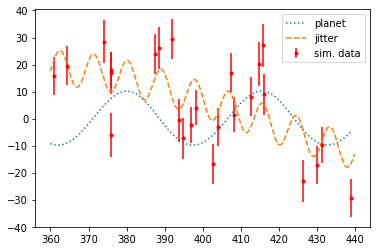

In [11]:
#plt.errorbar(x_rv,y_rv,yerr=yerr_rv,fmt='.')
plt.errorbar(x_rv,y_rv,yerr=yerr_rv,fmt='.r',label='sim. data')
plt.plot(np.arange(360,440,1),
         true_orbit.get_radial_velocity(np.arange(360,440,1), K=10).eval(),':',label='planet')
plt.plot(np.arange(360,440,0.1),
         6.5*np.sin(np.pi*2*(np.arange(360,440,0.1)-jitt0s[0])/(jitps[0])) + 19*np.sin(np.pi*2*(np.arange(360,440,0.1)-jitt0s[1])/(jitps[1])),'--',label='jitter')
plt.legend()

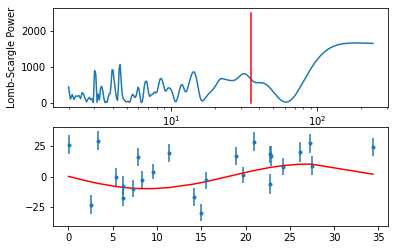

In [12]:
#Doing a lomb-scargle periodogram from scipy:
import scipy
periods = np.linspace(2, 240, 4000)
ang_freqs = 2 * np.pi / periods
power = scipy.signal.lombscargle(x_rv, y_rv, ang_freqs)
out=(x_rv,y_rv)

# plot the results
plt.subplot(211)
plt.plot(periods, power)
plt.xlabel('period (days)')
plt.ylabel('Lomb-Scargle Power')
plt.xscale('log')
plt.plot([35.36789,35.36789],[0,2500],'-r')
plt.subplot(212)
p=35.36789
phase=(x_rv-it0)%p
plt.errorbar(phase,y_rv,yerr=yerr_rv,fmt='.')
plt.plot(np.sort(phase),pure_rvs[np.argsort(phase)],'-r')

Ok, that looks passable. Whatever peak is there is not particularly high or well-resolved. The _raw_ SNR (i.e. ignoring the jitter and trend) is less than 6 ($10/9*\sqrt{25}$ =5.55). This is not going to be easy, but let's see how our model performs...

First we need to initialise the model. We can compile our x, y, yerr, etc into a dictionary. Let's also assume solar-like parameters

In [17]:
lc={'time':x,'flux':1000*(y-1),'flux_err':yerr*1000,
    'cadence':np.tile('t2',len(x)),'flux_unit':0.001,'jd_base':2457000}

mod=fit.monoModel('000000055','tess',lc=lc)

mod.init_starpars(Rstar=[1.0,0.05,0.05],
                  rhostar=[1.0,0.1,0.1],
                  Teff=[5700,120,120])

#### Adding RVs to the model

Here we need to add a dictionary with `'time'`, `'rv'`, `'rv_err'`, `'jd_base'` (though this can be left out if the RVs are in the same time format as the lightcurve), and `'rv_unit'` (which defaults to assuming m/s).

For the moment the model only works assuming a single telescope (i.e. it does not compute e.g. inter-instrument offsets). 

We can also specify here the complexity of the polynomial we want to include to fit RV trends - let's use a linear trend, i.e. n_poly_trend=2, which is the default.

In [18]:
mod.add_rvs({'time':x_rv,'rv':y_rv,'rv_err':yerr_rv,'jd_base':2457000,'rv_unit':'ms'},n_poly_trend=2)

Assuming all one telescope (HARPS).


In [19]:
#mod.add_duo({'tcen':105.57,'tcen_2':244.53,'tdur':0.21,'depth':idepth},'00')
#mod.add_multi({'tcen':105.57,'period':17.36789,'period_err':0.0025,'tdur':0.21,'depth':5e-3,'b':0.25},'00')
mod.add_duo({'tcen':105.57,'tcen_2':317.78,'tdur':0.275,'depth':idepth},'00')

Initialising the model. There is once again a long list of potential inputs as can be seen on the `FitExample.ipynb` notebook. 

One extra to be aware of here is:

- derive_k - bool - If we have RVs, do we derive K for each alias or fit for a single K param?

The default here is that we _derive_ a semi-amplitude for each model step. This works by using the model parameters to generate a normalised rv and then performing linear least-squares to get the amplitude. The alternative - fitting for a single global semi-amplitude - _is_ possible with MonoTools.fit, but it tends not to be a good idea as it might get "stuck" at small values in the wrong aliases.

In [20]:
mod.init_model(use_GP=False)

optimizing logp for variables: [tdur_00, b_00, logror_00]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -11513.615243789798 -> -11509.719936193269
optimizing logp for variables: [t0_2_00, logror_00]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -11509.719936193269 -> -11509.68302307898
optimizing logp for variables: [tdur_00, b_00, logror_00, t0_00, logrho_S]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -11509.683023078978 -> -11509.683023078978
optimizing logp for variables: [mean, logrho_S, Rs, rv_logs2, rv_polys, logs2]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -11509.683023078978 -> -6604.9165115607575
optimizing logp for variables: [tdur_00, b_00, logror_00]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -6604.9165115607575 -> -6604.719597169542
optimizing logp for variables: [u_star_tess, logrho_S, Rs, logs2, mean, rv_logs2, rv_polys, tdur_00, b_00, logror_00, t0_00]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -6604.719597169542 -> -6603.749877630451
optimizing logp for variables: [rv_logs2, rv_polys, logs2, mean, u_star_tess, tdur_00, b_00, logror_00, t0_2_00, t0_00, Rs, logrho_S]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -6603.749877630451 -> -6603.255994915614


### Plotting best-fit

Ok, here we can plot the best-fit photometry and RVs. We can choose either to plot all the aliases, or to simply plot the best N aliases (based on marginalised probabilities).

The plots here have alpha sorted by logprob, so the worst RV curves are somewhat hard to see. But the best one looks good!

19 23
13 19
7 13
0 7
7.290703548855469
5.382189943957174 -5.383325974415304
7.947344756805685
7.946842115232077 -7.94696284972207
7.8845198926806335
7.883004618421195 -7.8766524548380845
9.02200970421431
9.021949529951485 -9.022000789870589


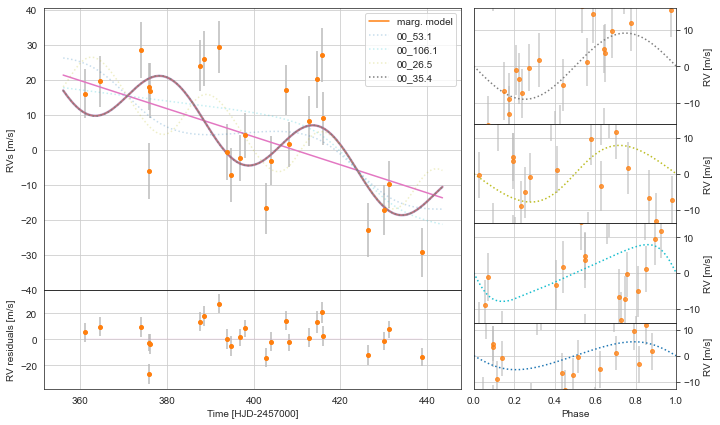

In [21]:
#mod.Plot(n_samp=1)
mod.PlotRVs(plot_alias='best', nbest=4, n_samp=1)

[0.5 0.5] [ 0 12 24] 32 range(0, 2)
initialising transit
Initalising Transit models for plotting with n_samp= 1


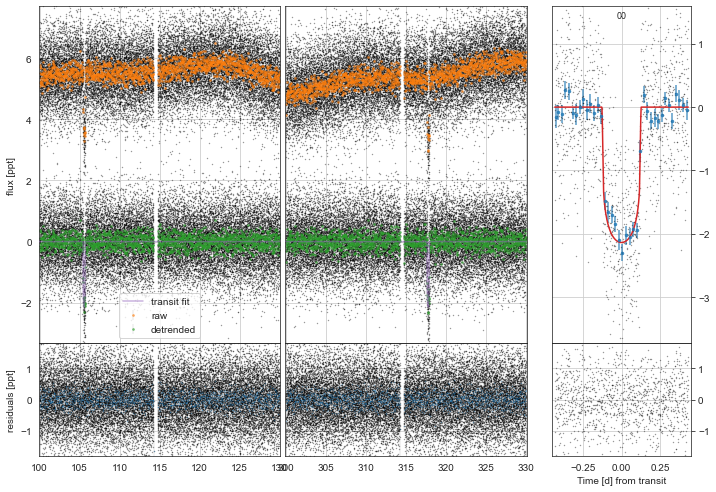

In [22]:
mod.Plot(n_samp=1)

The looks good! Let's run the MCMC

In [23]:
mod.RunMcmc(n_samp=150)

['/Volumes/LUVOIR/MonoToolsData/TIC00000000055/TIC00000000055_2021-04-15_1', '/Volumes/LUVOIR/MonoToolsData/TIC00000000055/TIC00000000055'] False


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_logs2, rv_polys, logs2, mean, u_star_tess, tdur_00, b_00, logror_00, t0_2_00, t0_00, Rs, logrho_S]
Sampling 4 chains, 0 divergences: 100%|██████████| 3320/3320 [17:58<00:00,  3.08draws/s]  
The acceptance probability does not match the target. It is 0.8376128983943959, but should be close to 0.9. Try to increase the number of tuning steps.


['gp_', '_gp', 'light_curve', '__', 'mono_uniform_index', 'logliks', '_priors', 'logprob_marg', 'mean', 'logrho_S', 'mono_pers', 'duo_pers', 'mono_eccs', 'duo_eccs', 'mono_omegas', 'duo_omegas'] ['Rs', 'logs2', 'rv_polys', 'rho_S', 'Ms', 't0_00', 't0_2_00', 'per_00', 'logror_00', 'ror_00', 'rpl_00', 'b_00', 'tdur_00', 'vel_00', 'logvel_00', 'min_ecc_00', 'omega_00', 'a_Rs_00', 'u_star_tess', 'rv_trend', 'rv_logs2', 'K_00', 'model_rv_00', 'Mp_00', 'rho_00', 'per_prior_00', 'max_ecc_00', 'v_prior_00', 'logprior_00', 'rv_loglik_00', 'logprob_00', 'ecc_00', 'ecc_marg_00', 'vel_marg_00', 'per_marg_00', 'marg_rv_model_00', 'Mp_marg_00', 'rho_marg_00', 'marg_all_lc_model', 'marg_all_rv_model']
Saving sampled model parameters to file with shape:  (6035, 16)


19 23
13 19
7 13
0 7


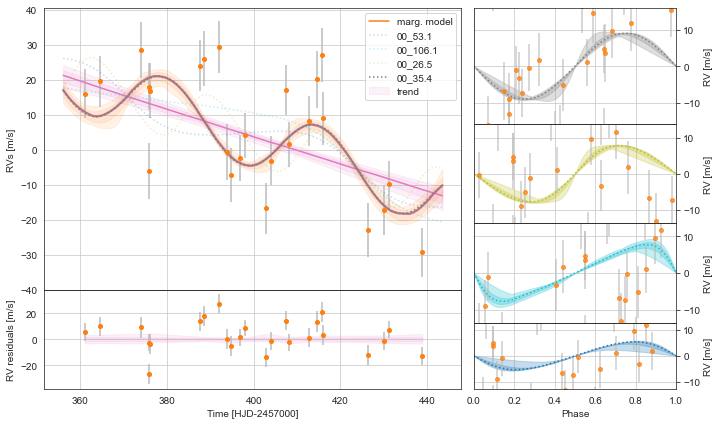

In [30]:
mod.PlotRVs(n_samp=120)

[0.5 0.5] [ 0 12 24] 32 range(0, 2)


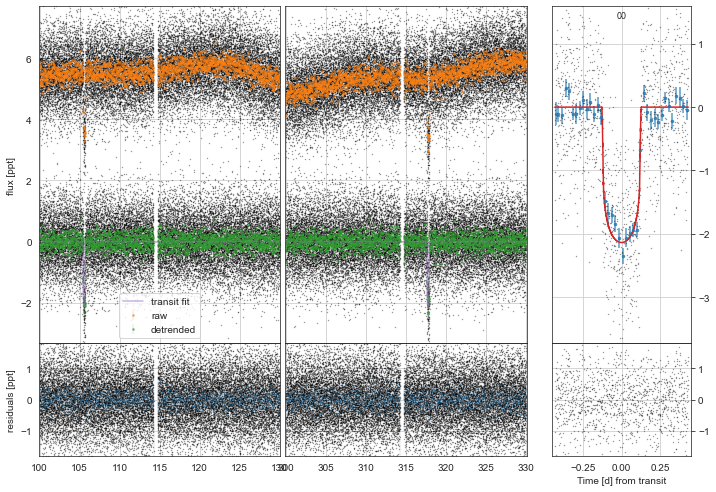

In [25]:
mod.Plot(n_samp=120)

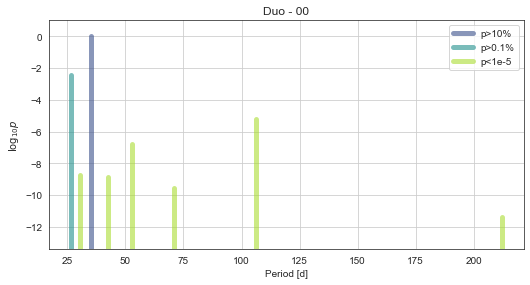

In [26]:
mod.PlotPeriods()

In [29]:
{str(mod.planets['00']['period_aliases'][n_alias])[:6]:np.exp(np.nanmedian(mod.trace['logprob_marg_00'][:,n_alias])) for n_alias in np.arange(mod.planets['00']['npers'])[::-1]}

{'26.526': 0.0036728138042365355,
 '30.315': 1.8168496908501564e-09,
 '35.368': 0.9963232728356446,
 '42.441': 1.449335389355645e-09,
 '53.052': 1.712634788077249e-07,
 '70.736': 2.6722934747659555e-10,
 '106.10': 5.922771845329371e-06,
 '212.20': 4.15298437965421e-12}

We have recovered the correct alias at pretty high confidence (99.63%)! Impressive

variables for Corner: ['logrho_S', 'logror_00', 'b_00', 'tdur_00', 't0_00', 't0_2_00', 'per_marg_00', 'ecc_marg_00']


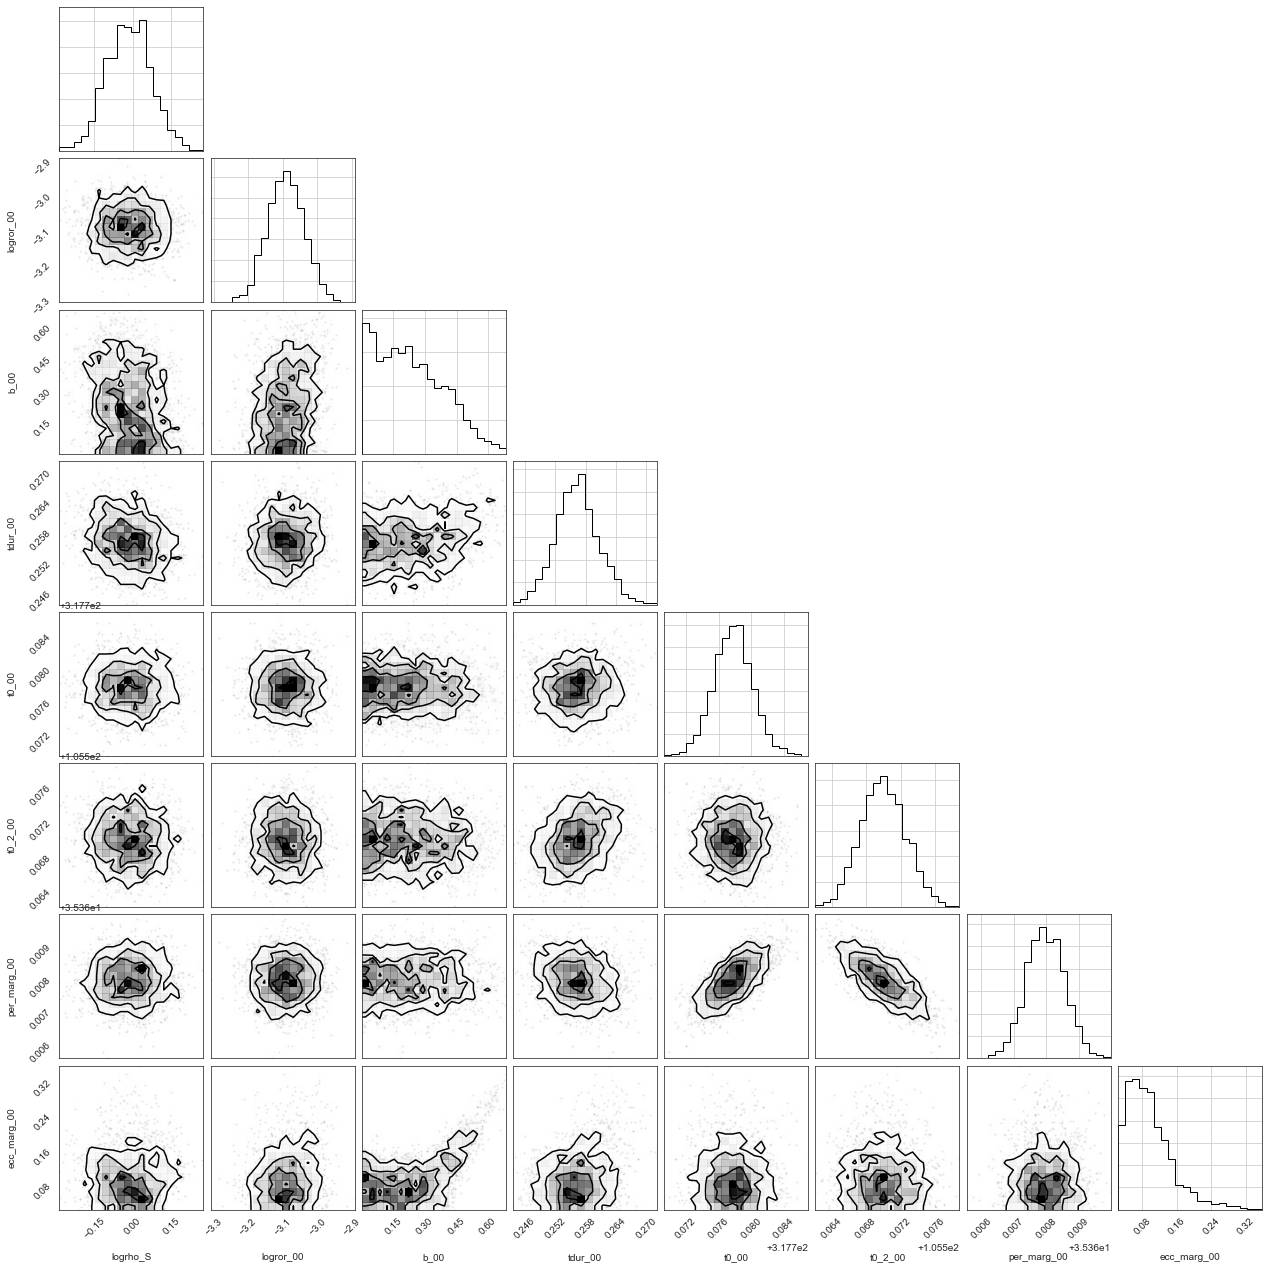

In [97]:
mod.PlotCorner()